## With alpha and L

In [1]:
# Uncomment first line to write changes to the package

In [2]:
# %%writefile ../NSGPy/NumPy/latent_lengthscale_model/latent_lengthscale_model.py
## Terminology is consistent with paper 
# Paper title: Nonstationary Gaussian Process Regression Using Point Estimates of Local Smoothness
# Authors: Christian Plagemann, Kristian Kersting, and Wolfram Burgard

#import jax.numpy as jnp
import numpy as np
from scipy.optimize import minimize
from scipy.special import kv, gamma
# from jax import jit, grad
# from jax.scipy.optimize import minimize
from sklearn.cluster import KMeans
import scipy

class LLS:
    """
    Latent lengthscale kernel
    We have the "main GP" and the "lengthscale GP" to model the lengthscales of the "main GP"
    
    input_dim: int, Input dimentions 
    
    sigma_f: float, Main GP variance 
    
    sigma_n: float, Main GP noise varaince
    
    N_l_bar: int, Number of support points (x_bar) where lengthscale will be learnt
    
    sigma_f_bar: float, Lengthscale GP variance
    
    sigma_l_bar: float, Lengthscale GP lengthscale
    
    sigma_n_bar: float, Lengthscale GP noise variance
    
    l_bar: numpy.ndarray, Lenthscales vector at support points (x_bar)
    
    optimizer: str, ('scipy', 'jax'), optimizer to use for hyperparameter learning 
    
    n_iter: int, Number of iterations (applicable on jax optimizer)
    
    lr: float, learning rate (applicable on jax optimizer)
    
    kernel: str, kernal name to use, 'rbf' or 'matern'
    
    nu: float, a hyperparameter in 'matern' kernel
    
    pruned_kernel: Under development
    
    full_l_mat: Under development
    
    N_l_bar_method: Under development
    
    seed: int, random seed for numpy random parameter initializations
    
    """
    def __init__(self, input_dim, sigma_f=None, sigma_n=None, N_l_bar=5,
                 sigma_f_bar=None, sigma_l_bar=None, sigma_n_bar=None, 
                 l_bar=None, bounds = (10**-5,10**5), optimizer='scipy', method='L-BFGS-B',
                 n_iter=20, lr=0.1, seed=0, kernel='rbf', nu=1.5, l_isotropic=False,
                 pruned_kernel=False, full_l_mat=False, N_l_bar_method='uniform', 
                 store_history=True):
        
        self.seed = seed
        np.random.seed(self.seed)
        self.input_dim = int(input_dim) 
        self.sigma_f = np.abs(np.random.rand(1)) if sigma_f is None else np.array(sigma_f).reshape(1,) 
        self.sigma_n = np.abs(np.random.rand(1)) if sigma_n is None else np.array(sigma_f).reshape(1,)
        self.N_l_bar = int(N_l_bar)
        self.l_isotropic = l_isotropic
        
        if self.l_isotropic:
            self.sigma_f_bar = np.abs(np.random.rand(1)) if sigma_f_bar is None else np.array(sigma_f_bar)
            self.sigma_l_bar = np.abs(np.random.rand(1)) if sigma_l_bar is None else np.array(sigma_l_bar)
            self.sigma_n_bar = np.abs(np.random.rand(1)) if sigma_n_bar is None else np.array(sigma_n_bar)
            assert self.sigma_f_bar.size == 1
            assert self.sigma_l_bar.size == 1
            assert self.sigma_n_bar.size == 1
        else:
            self.sigma_f_bar = np.abs(np.random.rand(input_dim)) if sigma_f_bar is None else np.array(sigma_f_bar)
            self.sigma_l_bar = np.abs(np.random.rand(input_dim)) if sigma_l_bar is None else np.array(sigma_l_bar)
            self.sigma_n_bar = np.abs(np.random.rand(input_dim)) if sigma_n_bar is None else np.array(sigma_n_bar)
            assert self.sigma_f_bar.size == input_dim
            assert self.sigma_l_bar.size == input_dim
            assert self.sigma_n_bar.size == input_dim
        
        self.l_bar = np.abs(np.random.rand(N_l_bar, input_dim)) if l_bar is None else np.array(l_bar)
        assert self.l_bar.shape == (N_l_bar, input_dim)
        
        self.optimizer = optimizer           # Optimizer to use for parameters learning
        self.n_iter = n_iter                 # Number of iterations (for jax optimizer)
        self.lr = lr                         # Learning rate (for jax optimizer)
        self.store_history = store_history   # Store history (bool) (for jax optimizer)
        self.bounds = bounds                 # parameter bounds
        self.method = method                 # method for optimization (for scipy optimizer)
        self.kernel = kernel                 # Kernel to use for main GP
        self.nu = nu                         # Exponent for Matern kernel
        
        self.pruned_kernel = pruned_kernel   # Use unnormalized Main GP kernel (Not implemented yet)
        self.full_l_mat = full_l_mat         # Use complete lengthscale matrix (Not implemented yet)
        self.N_l_bar_method = N_l_bar_method # Method to choose support points (Not implemented yet)
        
        self.params = {'GP_variance (sigma_f)':self.sigma_f, 
                       'GP_noise_level (sigma_n)':self.sigma_n, 
                       'Lengthscale_GP_variance (sigma_f_bar)':self.sigma_f_bar, 
                       'Lengthscale_GP_lengthscale (sigma_l_bar)':self.sigma_l_bar, 
                       'Lengthscale_GP_noise_level (sigma_n_bar)':self.sigma_n_bar,
                       'learnt_lengthscales (l_bar)':self.l_bar}
    
    def K_bar(self, sigma_f_bar, sigma_l_bar, X_bar_1, X_bar_2=None): # RBF kernel for lengthscale GP for training
        """
        This method is for internal usage and should not be called directly.
        
        X_bar_1, X_bar_2: np.ndarray with shape (N_l_bar, input_dim)
        sigma_f, sigma_n: int, variance (unsquared) and noise variance (unsquared)
        """
        if X_bar_2 is None:
            X_bar_2 = X_bar_1
            
        d = np.square(X_bar_1[:, np.newaxis, :] - X_bar_2[np.newaxis, :, :]) # 3D vectorized distance
        
        if self.l_isotropic: # If lengthscale GP is isotropic
            k = np.exp(-d/(sigma_l_bar**2))
            return k*sigma_f_bar**2
        else:
            k = np.exp(-d/(sigma_l_bar.reshape(1,1,self.input_dim)**2))
            return k*sigma_f_bar.reshape(1,1,self.input_dim)**2
        
    def K_bar_(self, X_bar_1, X_bar_2=None): # RBF kernel for lengthscale GP for prediction
        """
        X_bar_1, X_bar_2: np.ndarray with shape (N_l_bar, input_dim)
        sigma_f, sigma_n: int, variance (unsquared) and noise variance (unsquared)
        """
        return self.K_bar(self.sigma_f_bar, self.sigma_l_bar, X_bar_1, X_bar_2)
    
    def predict_lengthscales(self, X, sigma_f_bar, sigma_l_bar, 
                             sigma_n_bar, l_bar): # This method is used in training
        """
        This method is for internal usage and should not be called directly.
        
        Predicting lengthscales at X from learn lengthscales at X_bar (With GP inference)
        """
        
        self.K__X_bar__X_bar = self.K_bar(sigma_f_bar, sigma_l_bar, self.X_bar, X_bar_2=None)
        self.K__X__X_bar = self.K_bar(sigma_f_bar, sigma_l_bar, X, self.X_bar)
        
        L_barL = [] # storing L for each dimention (L is lower triangular cholesky decomposition)
        alphaL = [] # storing alpha for each dimention (alpha is derived from L_bar and l_bar)
        p,q,r = self.K__X_bar__X_bar.shape
        
        for dim in range(self.input_dim): # Oops, No vectorization available
            if self.l_isotropic:
                if self.optimizer == 'jax':
                    self.K__X_bar__X_bar = self.K__X_bar__X_bar.ravel().at[::p*r+r]\
                    .add(sigma_n_bar).reshape(p,q,r)  # Add noise variance to diagonal
                elif self.optimizer == 'scipy':
                    self.K__X_bar__X_bar.ravel()[dim::p*r+r] += sigma_n_bar # Add noise variance to diagonal
                else:
                    raise NotImplementedError('LLS: Optimizer: '+self.optimizer+' is not implemented')
            else:
                if self.optimizer == 'jax':
                    self.K__X_bar__X_bar = self.K__X_bar__X_bar.ravel().at[::p*r+r]\
                    .add(sigma_n_bar[dim]).reshape(p,q,r) # Add noise variance to diagonal
                elif self.optimizer == 'scipy':
                    self.K__X_bar__X_bar.ravel()[dim::p*r+r] += sigma_n_bar[dim] # Add noise variance to diagonal
                else:
                    raise NotImplementedError('LLS: Optimizer: '+self.optimizer+' is not implemented')

            tmp_L_bar = np.linalg.cholesky(self.K__X_bar__X_bar[:,:,dim])           # Cholesky decomposition
            tmp_alpha_bar = scipy.linalg.cho_solve((tmp_L_bar, True), np.log(l_bar[:,dim:dim+1]))
                                                                                    # derive alpha from L_bar and l_bar
            L_barL.append(tmp_L_bar[:,:,np.newaxis])
            alphaL.append(tmp_alpha_bar[:,np.newaxis,:])
        
        self.alpha_bar = np.concatenate(alphaL, axis=1) # vectorize alpha_bar
        self.L_bar = np.concatenate(L_barL, axis=2) # vectorize L_bar
    
        l = np.exp(np.einsum('pqr,qrs->pr', self.K__X__X_bar, self.alpha_bar)) # vectorized predicted lengthscales

        return l
    
    def predict_lengthscales_(self, X): # Predict lengthscales at predict time
        """
        Predicting lengthscales at X from learn lengthscales at X_bar (With GP inference)
        """
        return self.predict_lengthscales(X, self.sigma_f_bar, self.sigma_l_bar, 
                                    self.sigma_n_bar, self.l_bar)
    
    def K(self, sigma_f, Xi, li, Xj=None, lj=None, diag=False): # From Eq. 7, Main kernel for training
        """
        This method is for internal usage and should not be called directly.
        
        for scaler inputs 
        K(x_i, x_j) = ((l_i^2)**0.25)*((l_j^2)**0.25)*(0.5**-0.5)*((l_i^2+l_j^2)**-0.5)*(exp(2*D/(l_i^2+l_j^2)))
        for vector inputs (NumPy syntax)
        K(X_i, X_j) = ((L_i^2@L_j.T^2)**0.25)*(0.5**-0.5)*((L_i^2+L_j.T^2)**-0.5)*(exp(2*D/(L_i^2+L_j.T^2)))
        for multidimentional case, everything multiply and log exponents sums up
        
        Xi, Xj: np.ndarray with shape (N, input_dim)
        li, lj: np.ndarray with shape (N, input_dim)
        sigma_f, sigma_n: int, variance (unsquared) and noise variance (unsquared)
        diag: (bool) return diagonal entries alone
        """
        
        l_sqr_i = np.square(li) # saving l^2 for computation reduction
        
        if Xj is None:
            Xj = Xi
            l_sqr_j = l_sqr_i
        else:
            l_sqr_j = np.square(lj)
            
        if self.kernel == 'rbf':
            if diag:
                P = np.square(l_sqr_i.prod(axis=1))    # 3d vectorized diagonal (l_i^2) * (l_i^2)
                P_s = 2 * l_sqr_i.prod(axis=1)         # 3d vectorized diagonal (l_i^2) + (l_i^2)
                k = np.sqrt(np.sqrt(P))/np.sqrt(P_s)
            else:
                P = l_sqr_i.prod(axis=1)[:,np.newaxis]@l_sqr_j.prod(axis=1)[np.newaxis,:]    # 3d vectorized (l_i^2) * (l_j^2)
                P_s = (l_sqr_i[:, np.newaxis, :] + l_sqr_j[np.newaxis, :, :]) # 3d vectorized (l_i^2) + (l_j^2)
                D = (np.square(Xi[:, np.newaxis, :] - Xj[np.newaxis, :, :])/P_s).sum(axis=2) # 3d vectorized d^2 / P_s
                k = ((np.sqrt(np.sqrt(P)))/(np.sqrt(P_s.prod(axis=2))))*np.exp(-2*D)  # Eq. 7, Put everything togather

            return k*(sigma_f**2*0.5**-0.5) # Multiplying scalers at the end
        
        elif self.kernel == 'matern':
            P = l_sqr_i.prod(axis=1)[:,np.newaxis]@l_sqr_j.prod(axis=1)[np.newaxis,:]    # 3d vectorized (l_i^2) * (l_j^2)
            P_s = (l_sqr_i[:, np.newaxis, :] + l_sqr_j[np.newaxis, :, :])                # 3d vectorized (l_i^2) + (l_j^2)
            Q = np.sqrt((np.square(Xi[:, np.newaxis, :] - Xj[np.newaxis, :, :])/P_s).sum(axis=2))
                                                                                         # 3d vectorized nu * d^2 / P_s
            root_nu_Q = np.maximum(np.sqrt(self.nu)*Q, 10**-10) # kv function returns inf for 0, so setting 0 to 10**-10
            k = (np.sqrt(np.sqrt(P))/np.sqrt(P_s.prod(axis=2)))*\
                                        np.power(root_nu_Q, self.nu)*\
                                        kv(self.nu,2*root_nu_Q)        
            return k*((sigma_f**2)*2*np.sqrt(2))/gamma(self.nu)
    
    def K_(self, Xi, li, Xj=None, lj=None, diag=False): # Main kernel for predictions
        """
        for scaler inputs 
        K(x_i, x_j) = ((l_i^2)**0.25)*((l_j^2)**0.25)*(0.5**-0.5)*((l_i^2+l_j^2)**-0.5)*(exp(2*D/(l_i^2+l_j^2)))
        for vector inputs (NumPy syntax)
        K(X_i, X_j) = ((L_i^2@L_j.T^2)**0.25)*(0.5**-0.5)*((L_i^2+L_j.T^2)**-0.5)*(exp(2*D/(L_i^2+L_j.T^2)))
        for multidimentional case, everything multiply and log exponents sums up
        
        Xi, Xj: np.ndarray with shape (N, input_dim)
        li, lj: np.ndarray with shape (N, input_dim)
        sigma_f, sigma_n: int, variance (unsquared) and noise variance (unsquared)
        diag: (bool) return diagonal entries alone
        """
        return self.K(self.sigma_f, Xi, li, Xj, lj, diag)
        
    def parse_params(self, params): # parsing parameters from a signle array
        sigma_f = params[0:1]
        sigma_n = params[1:2]
        if self.l_isotropic:
            sigma_f_bar = params[2:3]
            sigma_l_bar = params[3:4]
            sigma_n_bar = params[4:5]
            l_bar = params[5:].reshape(self.X_bar.shape[0], self.input_dim)
        else:
            sigma_f_bar = params[2:2+self.input_dim]
            sigma_l_bar = params[2+self.input_dim:2+self.input_dim*2]
            sigma_n_bar = params[2+self.input_dim*2:2+self.input_dim*3]
            l_bar = params[2+self.input_dim*3:].reshape(self.X_bar.shape[0], self.input_dim)
        
        return sigma_f, sigma_n, sigma_f_bar, sigma_l_bar, sigma_n_bar, l_bar
        
    def mll(self, params): # Marginal log likelihood from equation 6 in section 4.1 
        """
        This method is for internal usage and should not be called directly.
        
        Marginal log likelihood given parameters. L(theta)->mll(params)
        """
        # parsing parameters
        sigma_f, sigma_n, sigma_f_bar, sigma_l_bar, sigma_n_bar, l_bar = self.parse_params(params)
        
        # Calculations for lengthscale GP
        self.l = self.predict_lengthscales(self.X, sigma_f_bar, sigma_l_bar, sigma_n_bar, l_bar)
        
        # Calculations for Main GP
        self.K_XX = self.K(sigma_f, self.X, self.l, Xj=None, lj=None)
        p,_ = self.K_XX.shape

        self.K_XX.ravel()[::p+1] += sigma_n # adding noise variance to diagonal
        
        self.L = np.linalg.cholesky(self.K_XX)
        self.alpha = scipy.linalg.cho_solve((self.L, True), self.y)
        
        L_theta =  (self.y.T@self.alpha).squeeze() +\
                    np.sum(np.log(np.diag(self.L))) # adding chol. decomp. of Main_GP
        for dim in range(self.input_dim): # adding chol. decomp. of Lengthscale_GP for each dimention
            L_theta += np.sum(np.log(np.diag(self.L_bar[:,:,dim])))
        return L_theta
    
    def custom_mll(self, X, y):
        """
        Marginal log likelihood given parameters for any X and y. L(theta)->mll(params)
        """
        # Calculations for lengthscale GP
        l = self.predict_lengthscales(X, self.sigma_f_bar, self.sigma_l_bar, self.sigma_n_bar, self.l_bar)
        
        # Calculations for Main GP
        K_XX = self.K(self.sigma_f, X, l, Xj=None, lj=None)
        p,_ = K_XX.shape

        K_XX.ravel()[::p+1] += self.sigma_n # adding noise variance to diagonal
        
        L = np.linalg.cholesky(K_XX)
        alpha = scipy.linalg.cho_solve((L, True), y)
        
        L_theta =  (y.T@alpha).squeeze() +\
                    np.sum(np.log(np.diag(L))) # adding chol. decomp. of Main_GP
        for dim in range(self.input_dim): # adding chol. decomp. of Lengthscale_GP for each dimention
            L_theta += np.sum(np.log(np.diag(self.L_bar[:,:,dim])))
        return L_theta
    
    def get_mll(self, sigma_f=None, sigma_n=None, sigma_f_bar=None, sigma_l_bar=None, sigma_n_bar=None, l_bar=None):
        """
        Enter only those parameters you want to change, others will be default to trained parameters.
        
        Marginal log likelihood given parameters. L(theta)->mll(params)
        """
        params = [sigma_f, sigma_n, sigma_f_bar, sigma_l_bar, sigma_n_bar, l_bar]
        fitted_params = [self.sigma_f, self.sigma_n, self.sigma_f_bar, self.sigma_l_bar, self.sigma_n_bar, self.l_bar.ravel()]
        for p_i in range(len(params)):
            if params[p_i] is None:
                params[p_i] = fitted_params[p_i]
        return self.mll(np.concatenate(params))

    def fit(self, X, y, n_restarts=5):
        """
        Fit method for learning hyperparameters of GP
        
        X: np.ndarray, (*, input_dim)
        y: np.ndarray, (*, 1)
        n_restarts: how many different initializations of hyperparameters?
        """
        assert len(X.shape) == 2, "shape of X must be 2D"
        assert len(y.shape) == 2, "shape of y must be 2D"
        assert y.shape[1] == 1, "y must be of shape (*,1)"

        self.X = X
        self.y = y
        
        if self.N_l_bar <= self.X.shape[0]:
            kmeans = KMeans(n_clusters=self.N_l_bar, random_state=0)
            self.X_bar = np.array(kmeans.fit(X).cluster_centers_).reshape(self.N_l_bar, self.input_dim)
        else:
            self.X_bar = X
            self.l_bar = np.abs(np.random.rand(self.X_bar.shape[0], self.input_dim))
        
        self.N_l_bar = len(self.X_bar)
        params = np.concatenate([self.sigma_f, self.sigma_n, self.sigma_f_bar,
                                     self.sigma_l_bar, self.sigma_n_bar, self.l_bar.ravel()])

        if self.optimizer=='scipy':
            optim_fun_val = np.inf
            fit_flag = 0 # fitted or not in any iterations
            for it in range(n_restarts): # Multiple restarts of optimizer
                try:
                    bounds = [self.bounds for _ in range(len(params))]
                    ########### Set internal bounds ##################
#                     bounds[1] = (10**-10, 100) # for sigma_n, GP_noise, should not be too high
                    if self.l_isotropic:
#                         bounds[2] = (10**-2, 10**5) # sigma_f_bar, should not be too low
#                         bounds[4] = (10**-5, 100) # for sigma_n_bar, L_GP_noise, should not be too high
                        pass
                    else:
#                         bounds[2:2+self.input_dim] = [(10**-2, 10**5) for _ in range(self.input_dim)] #lower bound
#                         bounds[2+self.input_dim*2:2+self.input_dim*3] = [(10**-5, 100) for _ in range(self.input_dim)]
                        pass
                    #############################
                    res = scipy.optimize.minimize(self.mll, params, bounds=bounds, 
                                                  method=self.method)
                    
                    if res.fun<optim_fun_val:
                        optim_fun_val = res.fun
                        params = res.x
                        self.sigma_f, self.sigma_n, self.sigma_f_bar,\
                        self.sigma_l_bar, self.sigma_n_bar, self.l_bar = self.parse_params(params)
                        fit_flag = 1
                
                except np.linalg.LinAlgError as e:
                    if e.__str__() == 'Matrix is not positive definite':
                        pass # Nothing to do. hoping to converge in another initialization
                    else:
                        raise np.linalg.LinAlgError('LLS: New error: '+e.__str__())
                
                except ValueError as e:
                    if e.__str__() == 'array must not contain infs or NaNs':
                        pass # Nothing to do. hoping to converge in another initialization
                    else:
                        raise ValueError('LLS: New error: '+e.__str__())
                        
                np.random.seed(it+1) # setting random seed for next iteration
                params = np.abs(np.random.rand(len(params))) # setting random params for next iteration
            
            assert fit_flag==1, 'LLS: Not fitted in any iterations'

############ Not implemented yet ########
#         elif self.optimizer=='jax': # add jit later
#             self.history = {'loss':[], 'grads':[]}
#             for iteration in range(self.n_iter):
#                 grads = grad(self.mll)(params)
#                 params = np.array(params - self.lr*grads).clip(10**-5, 10**5)
#                 if self.store_history:
#                     self.history['loss'].append(self.mll(params)) # remove after verification
#                     self.history['grads'].append(grads)
#             self.sigma_f, self.sigma_n, self.sigma_f_bar,\
#             self.sigma_l_bar, self.sigma_n_bar, self.l_bar = self.parse_params(params)
#########################################
    
        self.params = {'likelihood (mll)':optim_fun_val, 
                       'GP_variance (sigma_f)':self.sigma_f,
                       'GP_noise_level (sigma_n)':self.sigma_n, 
                       'L_GP_variance (sigma_f_bar)':self.sigma_f_bar, 
                       'L_GP_lengthscale (sigma_l_bar)':self.sigma_l_bar, 
                       'L_GP_noise_level (sigma_n_bar)':self.sigma_n_bar,
                       'N_lengthscales (l_bar)':self.l_bar}

    def get_params(self): # Get model parameters
        return self.params

    def predict(self, X_star, return_cov=True, diag=True): # Predicting output
        """
        Predict method to predict outputs.
        
        X_star: np.ndarray, (*, input_dim)
        return_cov: bool, return covariance or not
        diag: bool, return only diagonal entries of covariance or not
        """
        self.X_star = X_star
        
        l_star = self.predict_lengthscales_(X_star) # l*
        l = self.predict_lengthscales_(self.X)
        K__X_star__X = self.K_(X_star, l_star, self.X, l) # K_X*_X
        K_XX = self.K_(self.X, l)
        p,_ = K_XX.shape
        K_XX.ravel()[::p+1] += self.sigma_n # adding noise variance to diagonal
        L = np.linalg.cholesky(K_XX)
        alpha = scipy.linalg.cho_solve((L, True), self.y)
        
        mean = K__X_star__X@alpha # K_X*_X@alpha    
        if return_cov:
            v = scipy.linalg.cho_solve((L, True), K__X_star__X.T)
            if diag: # return only diagonal entries of covariance
                cov = self.K_(X_star, l_star, diag=True) - (K__X_star__X@v).diagonal()
            else:
                cov = self.K_(X_star, l_star) - K__X_star__X@v
            return mean, cov
        return mean

## Step function (1d test)

shape of train_X= (20, 1) shape of train_y= (20, 1)


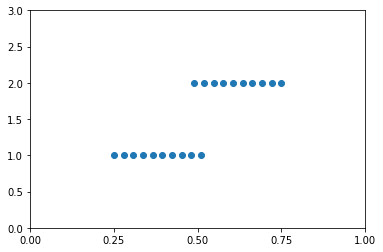

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
train_X = np.concatenate([np.linspace(0.25,0.51,10), np.linspace(0.49,0.75,10)]).reshape(-1,1)
train_y = np.concatenate([np.ones((10, 1)), np.ones((10, 1))*2])
test_X = np.linspace(0,1,120).reshape(-1,1)
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X, train_y)
plt.ylim(0,3);plt.xticks([0,0.25,0.5,0.75,1]);

(120,)
{'likelihood (mll)': -4.380923414076874, 'GP_variance (sigma_f)': array([1.27927358]), 'GP_noise_level (sigma_n)': array([0.15181679]), 'L_GP_variance (sigma_f_bar)': array([0.00090922]), 'L_GP_lengthscale (sigma_l_bar)': array([0.10821576]), 'L_GP_noise_level (sigma_n_bar)': array([1.e-05]), 'N_lengthscales (l_bar)': array([[36.49386052]])}
(120,)
{'likelihood (mll)': -10.04040881105104, 'GP_variance (sigma_f)': array([1.27537415]), 'GP_noise_level (sigma_n)': array([0.15357839]), 'L_GP_variance (sigma_f_bar)': array([1.e-05]), 'L_GP_lengthscale (sigma_l_bar)': array([0.14119583]), 'L_GP_noise_level (sigma_n_bar)': array([1.e-05]), 'N_lengthscales (l_bar)': array([[1.14055696],
       [1.06887428]])}
(120,)
{'likelihood (mll)': -15.796865561834709, 'GP_variance (sigma_f)': array([1.2753747]), 'GP_noise_level (sigma_n)': array([0.15357845]), 'L_GP_variance (sigma_f_bar)': array([1.e-05]), 'L_GP_lengthscale (sigma_l_bar)': array([0.23822517]), 'L_GP_noise_level (sigma_n_bar)': ar

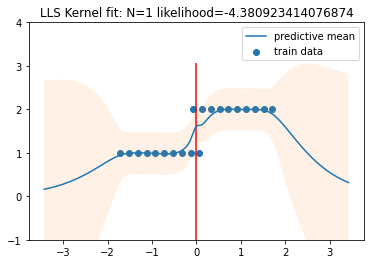

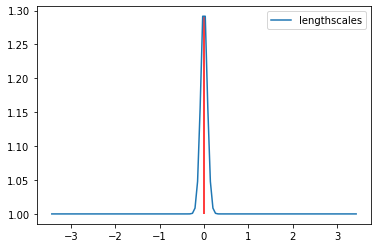

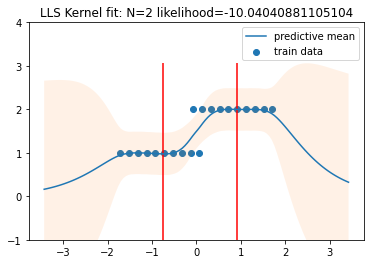

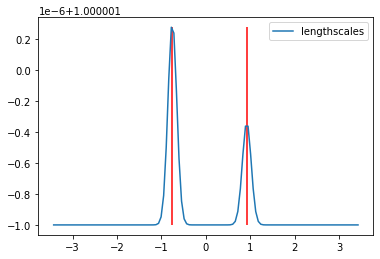

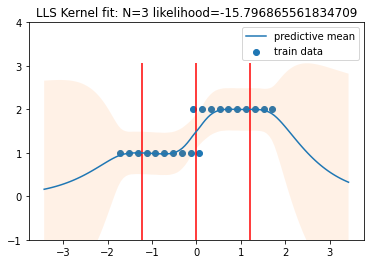

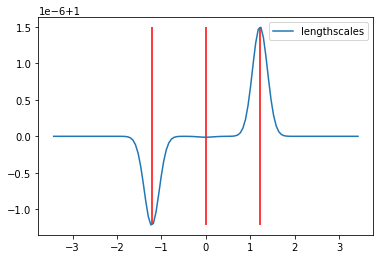

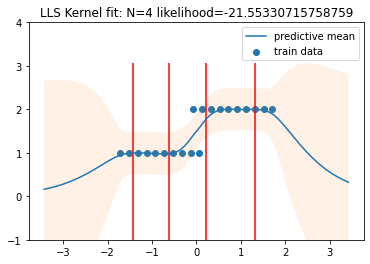

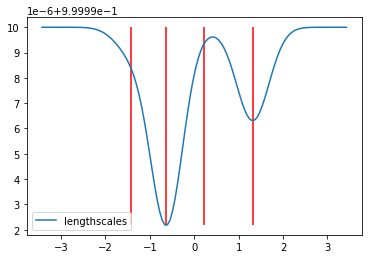

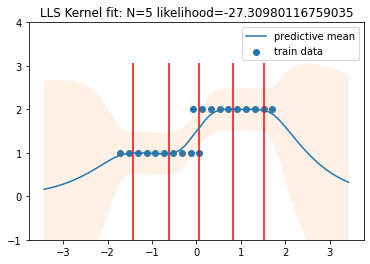

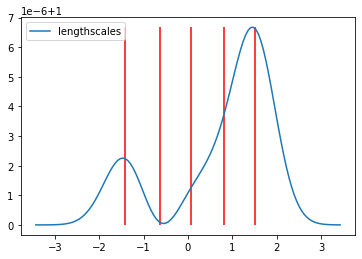

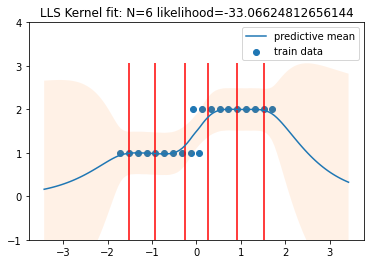

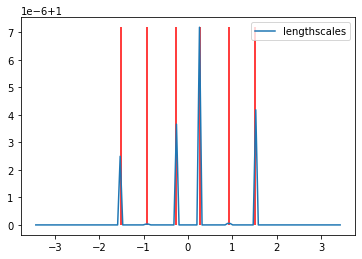

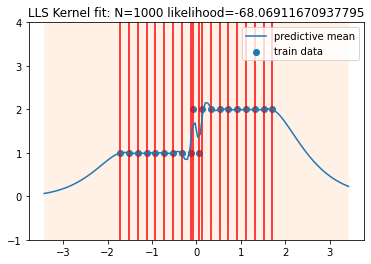

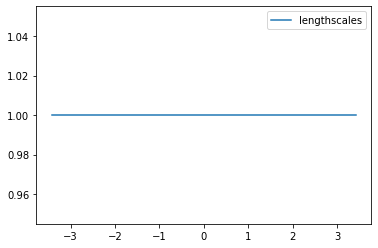

In [4]:
def fit_predict_plot(title):
    plt.figure()
    plt.ylim(-1,4)
    scaler = StandardScaler()
    train_XX = scaler.fit_transform(train_X)
    test_XX = scaler.transform(test_X)
    model.fit(train_XX, train_y, n_restarts=1)
    pred_y, pred_cov = model.predict(test_XX, return_cov=True, diag=False)
    pred_std = (pred_cov.diagonal()**0.5*2).squeeze()
    print(pred_std.shape)
    plt.scatter(train_XX, train_y, label='train data')
    plt.plot(test_XX, pred_y, label='predictive mean')
    plt.fill_between(test_XX.squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
    plt.title(title+' likelihood='+str(model.params['likelihood (mll)']))
    plt.vlines(model.X_bar, min(pred_y.squeeze()-pred_std), max(pred_y.squeeze()+pred_std), color='r')
    plt.legend()
    plt.figure()
    pred_l = model.predict_lengthscales_(test_XX)
    plt.plot(test_XX, pred_l, label='lengthscales')
    plt.vlines(model.X_bar, pred_l.min(), pred_l.max(), color='r')
    print(model.get_params())
    plt.legend()

for N in [1,2,3,4,5,6,1000]:
    model = LLS(1, N_l_bar=N, optimizer='scipy', kernel='matern')
    fit_predict_plot('LLS Kernel fit: N='+str(N))

# y = log(x1) = exp(x2) (2d test)

shape of train_X= (20, 2) shape of train_y= (20, 1)


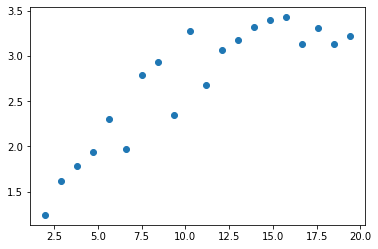

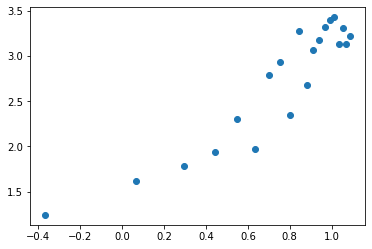

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
test_X1 = np.linspace(2,20,60).reshape(-1,1)
np.random.seed(0)
test_y = np.log(test_X1)
test_X2 = np.log(test_y)
test_y = test_y+np.random.rand(*test_X1.shape)
test_X = np.concatenate([test_X1, test_X2], axis=1)
train_X = test_X[::3]
train_y = test_y[::3]
print("shape of train_X=",train_X.shape, "shape of train_y=",train_y.shape)
plt.scatter(train_X[:,0], train_y);plt.figure();plt.scatter(train_X[:,1], train_y);

{'likelihood (mll)': -25.535607036999863, 'GP_variance (sigma_f)': array([8.42478229]), 'GP_noise_level (sigma_n)': array([0.10792075]), 'L_GP_variance (sigma_f_bar)': array([0.00251081, 0.00486714]), 'L_GP_lengthscale (sigma_l_bar)': array([276.57143251,  25.39655023]), 'L_GP_noise_level (sigma_n_bar)': array([1.e-05, 1.e-05]), 'N_lengthscales (l_bar)': array([[ 96.92530883, 253.00026697],
       [197.56233414,   5.07860678]])}


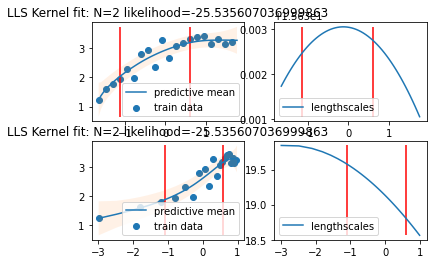

In [6]:
def fit_predict_plot(title):
    scaler = StandardScaler()
    train_XX = scaler.fit_transform(train_X)
    test_XX = scaler.transform(test_X)
    model.fit(train_XX, train_y)
    pred_y, pred_cov = model.predict(test_XX, return_cov=True)
    pred_std = (pred_cov.diagonal()**0.5*2).squeeze()
    pred_l = model.predict_lengthscales_(test_XX)
    fig, ax = plt.subplots(2,2)
    for fig_n in [0,1]:
        ax[fig_n,0].scatter(train_XX[:,fig_n], train_y, label='train data')
        ax[fig_n,0].plot(test_XX[:,fig_n], pred_y, label='predictive mean')
        ax[fig_n,0].fill_between(test_XX[:,fig_n].squeeze(), pred_y.squeeze()-pred_std, pred_y.squeeze()+pred_std, alpha=0.1)
        ax[fig_n,0].set_title(title+' likelihood='+str(model.params['likelihood (mll)']))
        ax[fig_n,0].vlines(model.X_bar[:,fig_n], min(pred_y.squeeze()-pred_std), max(pred_y.squeeze()+pred_std), color='r')
        ax[fig_n,0].legend()
        ax[fig_n,1].plot(test_XX[:,fig_n], pred_l[:,fig_n], label='lengthscales')
        ax[fig_n,1].vlines(model.X_bar[:,fig_n], pred_l[:,fig_n].min(), pred_l[:,fig_n].max(), color='r')
        ax[fig_n,1].legend()
    print(model.get_params())

for N in [2]:
    model = LLS(2, N_l_bar=N, optimizer='scipy', kernel='matern', bounds=(10**-5, 10**5))
    fit_predict_plot('LLS Kernel fit: N='+str(N))

# Benchmarking

### Which Methods are empirically fast??

## Vectorize or not?

In [7]:
from scipy.spatial.distance import cdist
x=np.random.rand(100,10)
y=np.random.rand(100,10)
ps = np.random.rand(100,100,10)

def m1():
    return (np.square(x[:, np.newaxis, :] - y[np.newaxis, :, :])/ps).sum(axis=2)

def m2():
    s = 0
    for i in range(x.shape[1]):
        s += (cdist(x[:,i:i+1], y[:,i:i+1], metric='sqeuclidean')/ps[:,:,i])
    return s

print(np.allclose(m1(), m2()))
%timeit m1()
%timeit m2()

True
498 µs ± 7.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
707 µs ± 1.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Cholesky calulations

In [8]:
a = np.random.rand(1000,1000)
a = a@a.T
b = np.abs(np.random.rand(100,1000))

y = np.random.rand(1000, 1)
def original():
    return b@np.linalg.inv(a)@y

def m1():
    L = np.linalg.cholesky(a)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    return b@alpha

def m2():
    L = np.linalg.cholesky(a)
    alpha = scipy.linalg.cho_solve((L, True), y)
    return b@alpha

def m3():
    L = scipy.linalg.cholesky(a, lower=True)
    alpha = scipy.linalg.cho_solve((L, True), y)
    return b@alpha
    

print(np.allclose(original(), m1()), 
      np.allclose(original(), m2()), 
      np.allclose(original(), m3()))
%timeit original()
%timeit m1()
%timeit m2()
%timeit m3()

True True True
356 ms ± 2.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
703 ms ± 3.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
34.9 ms ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
30.5 ms ± 118 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## np.sqrt v/s np.power

In [9]:
l1 = np.random.rand(1000, 1)
l2 = np.random.rand(1000, 1)

aaa = l1@l1.T
%timeit np.sqrt(np.sqrt(aaa))
%timeit np.power(aaa,0.25)
%timeit aaa ** 0.25

2.19 ms ± 4.34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
59.3 ms ± 81.8 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.3 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


## (First @ or *) or vectorize ??

In [10]:
l1 = np.random.rand(70, 3)
l2 = np.random.rand(70, 3)

def m1():
    m = 1
    for i in range(l1.shape[1]):
        m *= l1[:,i:i+1]@l2[:,i:i+1].T
    return m

def m2():
    ll1 =1;ll2=1
    for i in range(l1.shape[1]):
        ll1 *= l1[:,i:i+1]
        ll2 *= l2[:,i:i+1]
    return ll1@ll2.T

def m3():
    return l1.prod(axis=1)[:,np.newaxis]@l2.prod(axis=1)[np.newaxis,:]

print(np.allclose(m1(), m2()), np.allclose(m1(), m3()))

%timeit m1()
%timeit m2()
%timeit m3()

True True
48.9 µs ± 63.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.4 µs ± 56.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
19.4 µs ± 26.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## How to add noise variance to diagonal ?

In [11]:
kk = np.random.rand(200,200)
kk = kk@kk.T

def m1(kk):
    return kk + np.eye(kk.shape[0])*20
    
def m2(kk):
    np.fill_diagonal(kk, kk.diagonal() + 20)
    return kk

def m3(kk):
    kk.ravel()[::kk.shape[1]+1] += 20
    return kk

print(np.allclose(m1(kk), m2(kk)), np.allclose(m1(kk), m3(kk)))

%timeit m1(kk)
%timeit m2(kk)
%timeit m3(kk)

True True
44.9 µs ± 532 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
4.35 µs ± 17.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.93 µs ± 20.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Appendix